In [2]:
import sys
sys.path.insert(0, '/Users/eman/Documents/code_projects/kernellib')
sys.path.insert(0, '/home/emmanuel/code/kernellib')

In [3]:
import numpy as np
from kernellib.large_scale import RKSKernelRidge, KernelRidge as RKernelRidge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

### Large Scale Kernel Function

In [81]:
import numpy as np
from kernellib.kernel_approximation import RandomizedNystrom, RandomFourierFeatures
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.utils import check_array, check_X_y, check_random_state
from sklearn.utils.validation import check_is_fitted
from scipy.linalg import cholesky, cho_solve, solve
from sklearn.linear_model.ridge import _solve_cholesky_kernel

class KernelRidge(BaseEstimator, RegressorMixin):
    """Kernel Ridge Regression with kernel Approximations.


    Author: J. Emmanuel Johnson
    Email : jemanjohnson34@gmail.com
            emanjohnson91@gmail.com
    Date  : 3rd - August, 2018
    """
    def __init__(self, n_components=10, alpha=1e-3, sigma=None,
                 random_state=None, approximation='nystrom',
                 k_rank=10, kernel='rbf', trade_off='acc'):
        self.n_components = n_components
        self.alpha = alpha
        self.sigma = sigma
        self.random_state = random_state
        self.approximation = approximation
        self.k_rank = k_rank
        self.n_components = n_components
        self.kernel = kernel
        self.trade_off = trade_off

    def fit(self, X, y):

        # Convert the data
        X, y = check_X_y(X, y, accept_sparse=("csr", "csc"), multi_output=True,
                         y_numeric=True)

        # iniate randomization
        rng = check_random_state(self.random_state)
        
        # Sigma
        if self.sigma is None:
            self.sigma = 1.0

        # Kernel Approximation Step
        self.L = self._kernel_approximation(X)

        # Solve for weights
        K = np.dot(self.L.T, self.L)
        alpha = np.atleast_1d(self.alpha)

        ravel = False
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
            ravel = True

        if self.approximation == 'rnystrom':
            self.dual_coef_ = solve(K + alpha * np.eye(K.shape[0]), np.dot(self.L.T, y))
        else:
            self.dual_coef_ = _solve_cholesky_kernel(K, np.dot(self.L.T, y), alpha)

        if ravel:
            self.dual_coef_ = self.dual_coef_.ravel()

        self.X_fit_ = X


        return self

    def _kernel_approximation(self, X):

        # Random Fourier Features
        if self.approximation == 'rff':
            self.trans = RandomFourierFeatures(
                n_components=self.n_components,
                gamma=1 / np.sqrt(2 * self.sigma**2)
            )

        # RBF Sampler (Variant of Random Kitchen Sinks)
        elif self.approximation == 'rks':
            self.trans = RBFSampler(
                gamma=1 / np.sqrt(2 * self.sigma**2),
                n_components=self.n_components,
                random_state=self.random_state)

        # Nystrom Approximation
        elif self.approximation == 'nystrom':
            self.trans = Nystroem(
                kernel=self.kernel,
                gamma=1 / np.sqrt(2 * self.sigma**2),
                n_components=self.n_components
            )
        elif self.approximation == 'fastfood':
            self.trans = Fastfood(
                 sigma=self.sigma,
                 n_components=self.n_components,
                 tradeoff_mem_accuracy=self.trade_off,
                 random_state=self.random_state
            )
        # Randomized Nystrom Approximation
        elif self.approximation == 'rnystrom':
            self.trans = RandomizedNystrom(
                kernel=self.kernel,
                sigma=self.sigma,
                n_components=self.n_components,
                k_rank=self.k_rank,
                random_state=self.random_state
            )
        else:
            raise ValueError('Unrecognized algorithm.')

        self.trans.fit(X)

        return self.trans.transform(X)

    def predict(self, X):
        """Predict using the kernel ridge model
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Samples.
        Returns
        -------
        Predictions : array, shape = [n_samples] or [n_samples, n_targets]
            Returns predicted values.
        """
        check_is_fitted(self, ["X_fit_", "dual_coef_"])

        X = check_array(X)

        K = self.trans.transform(X)

        return np.real(np.dot(K, self.dual_coef_))




In [82]:
seed = 123
rng = np.random.RandomState(seed)
n_train, n_test = 10000, 1000
d_dimensions = 1
noise = 0.1

xtrain = rng.randn(n_train, d_dimensions)
ytrain = np.sin(xtrain) + noise * rng.randn(n_train, d_dimensions)

xtest = rng.randn(n_test, d_dimensions)
ytest = np.sin(xtest) + noise * rng.randn(n_test, d_dimensions)

# training
n_components = 10
alpha = 1e-3
sigma = 1.0

In [83]:
approximation = 'fastfood'
fastfood_model = KernelRidge(n_components=n_components,
                         alpha=alpha,
                         sigma=sigma,
                         kernel='rbf',
                         random_state=seed,
                         approximation=approximation,
                            trade_off='acc')
fastfood_model.fit(xtrain, ytrain);
y_pred = fastfood_model.predict(xtest)
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print('Root Mean Squared Error for FastFood KRR: {:.4f}'.format(rmse))

Root Mean Squared Error for FastFood KRR: 0.0999


In [84]:
%timeit fastfood_model.fit(xtrain, ytrain);
%timeit fastfood_model.predict(xtest);

6.18 ms ± 369 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
665 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


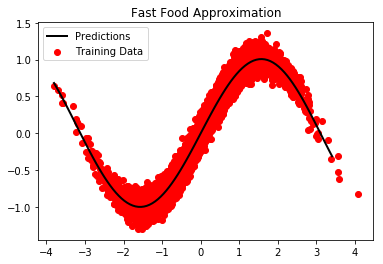

In [85]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = fastfood_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Fast Food Approximation')
plt.show()

### Fast Food Kernel Approximation

In [64]:
'''
Implementation of Fastfood (Le, Sarlos, and Smola, ICML 2013).
Primarily by @esc (Valentin Haenel) and felixmaximilian
from https://github.com/scikit-learn/scikit-learn/pull/3665.
Modified by @dougalsutherland.
FHT implementation was "inspired by" https://github.com/nbarbey/fht.
'''
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_random_state
from numpy.random import choice
from scipy.stats import chi

try:
    from sklearn.utils import check_array
except ImportError:
    from sklearn.utils import check_arrays

    def check_array(*args, **kwargs):
        X, = check_arrays(*args, **kwargs)
        return X


# In my tests, numba was just as fast as their Cython implementation,
# and it avoids compilation if you have it installed anyway.
from numba import jit

@jit(nopython=True)
def fht(array_):
    """ Pure Python implementation for educational purposes. """
    bit = length = len(array_)
    for _ in range(int(np.log2(length))):
        bit >>= 1
        for i in range(length):
            if i & bit == 0:
                j = i | bit
                temp = array_[i]
                array_[i] += array_[j]
                array_[j] = temp - array_[j]
                
@jit(nopython=True)
def is_power_of_two(input_integer):
    """ Test if an integer is a power of two. """
    if input_integer == 1:
        return False
    return input_integer != 0 and ((input_integer & (input_integer - 1)) == 0)

@jit(nopython=True)
def fht2(array_):
    """ Two dimensional row-wise FHT. """
    if not is_power_of_two(array_.shape[1]):
        raise ValueError('Length of rows for fht2 must be a power of two')

    for x in range(array_.shape[0]):
        fht(array_[x])



class Fastfood(BaseEstimator, TransformerMixin):
    """Approximates feature map of an RBF kernel by Monte Carlo approximation
    of its Fourier transform.
    Fastfood replaces the random matrix of Random Kitchen Sinks (RBFSampler)
    with an approximation that uses the Walsh-Hadamard transformation to gain
    significant speed and storage advantages.  The computational complexity for
    mapping a single example is O(n_components log d).  The space complexity is
    O(n_components).  Hint: n_components should be a power of two. If this is
    not the case, the next higher number that fulfills this constraint is
    chosen automatically.
    Parameters
    ----------
    sigma : float
        Parameter of RBF kernel: exp(-(1/(2*sigma^2)) * x^2)
    n_components : int
        Number of Monte Carlo samples per original feature.
        Equals the dimensionality of the computed feature space.
    tradeoff_mem_accuracy : "accuracy" or "mem", default: 'accuracy'
        mem:        This version is not as accurate as the option "accuracy",
                    but is consuming less memory.
        accuracy:   The final feature space is of dimension 2*n_components,
                    while being more accurate and consuming more memory.
    random_state : {int, RandomState}, optional
        If int, random_state is the seed used by the random number generator;
        if RandomState instance, random_state is the random number generator.
    Notes
    -----
    See "Fastfood | Approximating Kernel Expansions in Loglinear Time" by
    Quoc Le, Tamas Sarl and Alex Smola.
    Examples
    ----
    See scikit-learn-fastfood/examples/plot_digits_classification_fastfood.py
    for an example how to use fastfood with a primal classifier in comparison
    to an usual rbf-kernel with a dual classifier.
    """

    def __init__(self,
                 sigma=np.sqrt(1/2),
                 n_components=100,
                 tradeoff_mem_accuracy='acc',
                 random_state=None):
        self.sigma = sigma
        self.n_components = n_components
        self.random_state = random_state
        self.rng = check_random_state(self.random_state)
        # map to 2*n_components features or to n_components features with less
        # accuracy
        self.tradeoff_mem_accuracy = \
            tradeoff_mem_accuracy

    @staticmethod
    def enforce_dimensionality_constraints(d, n):
        if not is_power_of_two(d):
            # find d that fulfills 2^l
            d = np.power(2, np.floor(np.log2(d)) + 1)
        divisor, remainder = divmod(n, d)
        times_to_stack_v = int(divisor)
        if remainder != 0:
            # output info, that we increase n so that d is a divider of n
            n = (divisor + 1) * d
            times_to_stack_v = int(divisor+1)
        return int(d), int(n), times_to_stack_v

    def pad_with_zeros(self, X):
        try:
            X_padded = np.pad(X,
                              ((0, 0),
                               (0, self.number_of_features_to_pad_with_zeros)),
                              'constant')
        except AttributeError:
            zeros = np.zeros((X.shape[0],
                              self.number_of_features_to_pad_with_zeros))
            X_padded = np.concatenate((X, zeros), axis=1)

        return X_padded

    @staticmethod
    def approx_fourier_transformation_multi_dim(result):
        fht2(result)

    @staticmethod
    def l2norm_along_axis1(X):
        return np.sqrt(np.einsum('ij,ij->i', X, X))

    def uniform_vector(self):
        if self.tradeoff_mem_accuracy != 'acc':
            return self.rng.uniform(0, 2 * np.pi, size=self.n)
        else:
            return None

    def apply_approximate_gaussian_matrix(self, B, G, P, X):
        """ Create mapping of all x_i by applying B, G and P step-wise """
        num_examples = X.shape[0]

        result = np.multiply(B, X.reshape((1, num_examples, 1, self.d)))
        result = result.reshape((num_examples*self.times_to_stack_v, self.d))
        Fastfood.approx_fourier_transformation_multi_dim(result)
        result = result.reshape((num_examples, -1))
        np.take(result, P, axis=1, mode='wrap', out=result)
        np.multiply(np.ravel(G), result.reshape(num_examples, self.n),
                    out=result)
        result = result.reshape(num_examples*self.times_to_stack_v, self.d)
        Fastfood.approx_fourier_transformation_multi_dim(result)
        return result

    def scale_transformed_data(self, S, VX):
        """ Scale mapped data VX to match kernel(e.g. RBF-Kernel) """
        VX = VX.reshape(-1, self.times_to_stack_v*self.d)

        return (1 / (self.sigma * np.sqrt(self.d)) *
                np.multiply(np.ravel(S), VX))

    def phi(self, X):
        if self.tradeoff_mem_accuracy == 'acc':
            m, n = X.shape
            out = np.empty((m, 2 * n), dtype=X.dtype)
            np.cos(X, out=out[:, :n])
            np.sin(X, out=out[:, n:])
            out /= np.sqrt(X.shape[1])
            return out
        else:
            np.cos(X+self.U, X)
            return X * np.sqrt(2. / X.shape[1])

    def fit(self, X, y=None):
        """Fit the model with X.
        Samples a couple of random based vectors to approximate a Gaussian
        random projection matrix to generate n_components features.
        Parameters
        ----------
        X : {array-like}, shape (n_samples, n_features)
            Training data, where n_samples in the number of samples
            and n_features is the number of features.
        Returns
        -------
        self : object
            Returns the transformer.
        """
        X = check_array(X)

        d_orig = X.shape[1]

        self.d, self.n, self.times_to_stack_v = \
            Fastfood.enforce_dimensionality_constraints(d_orig,
                                                        self.n_components)
        self.number_of_features_to_pad_with_zeros = self.d - d_orig

        self.G = self.rng.normal(size=(self.times_to_stack_v, self.d))
        self.B = self.rng.choice([-1, 1],
                        size=(self.times_to_stack_v, self.d),
                        replace=True)
        self.P = np.hstack([(i*self.d)+self.rng.permutation(self.d)
                            for i in range(self.times_to_stack_v)])
        self.S = np.multiply(1 / self.l2norm_along_axis1(self.G)
                             .reshape((-1, 1)),
                             chi.rvs(self.d,
                                     size=(self.times_to_stack_v, self.d)))

        self.U = self.uniform_vector()

        return self

    def transform(self, X):
        """Apply the approximate feature map to X.
        Parameters
        ----------
        X : {array-like}, shape (n_samples, n_features)
            New data, where n_samples in the number of samples
            and n_features is the number of features.
        Returns
        -------
        X_new : array-like, shape (n_samples, n_components)
        """
        X = check_array(X)
        X_padded = self.pad_with_zeros(X)
        HGPHBX = self.apply_approximate_gaussian_matrix(self.B,
                                                        self.G,
                                                        self.P,
                                                        X_padded)
        VX = self.scale_transformed_data(self.S, HGPHBX)
        return self.phi(VX)